In [151]:
import tensorflow as tf
import pandas as pd
import numpy as np
from scipy import stats

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("whitegrid")

In [155]:
class MonteCarloDropoutNet:
    def __init__(
        self,
        ids,
        embed_size=1,
        dense_size=32,
        dense_dropout=0.5,
        learning_rate=0.01
    ):
        self.embed_size = embed_size
        self.dense_size = dense_size
        self.dense_dropout = dense_dropout
        self.learning_rate = learning_rate

        corpus = tf.data.Dataset.from_tensor_slices(ids)
        vectorization = tf.keras.layers.TextVectorization(
            split=None,
            max_tokens=len(ids)+2, # could be less
            output_mode="int",
            output_sequence_length=1,
            standardize=None
        )
        vectorization.adapt(corpus.batch(1024))
        print('Vocabulary: %s' % vectorization.get_vocabulary())

        input = tf.keras.Input(shape=(1,), dtype=tf.string, name="input")
        l = vectorization(input)
        l = tf.keras.layers.Embedding(vectorization.vocabulary_size(), self.embed_size, name="embedding")(l)
        l = tf.keras.layers.Dense(self.dense_size, activation="relu", name="features")(l)
        l = tf.keras.layers.Dropout(self.dense_dropout)(l, training=True)
        l = tf.keras.layers.Dense(1, activation="linear", name="decision")(l)
        self.model = tf.keras.models.Model(input, outputs=l, name="Net")

    def train(self, X_train, y_train, X_val, y_val):
        batch_size = int(len(X_train)/50)
        self.model.compile(
            optimizer=tf.keras.optimizers.Adam(learning_rate=self.learning_rate),
            loss=tf.keras.losses.MeanSquaredError()
        )

        es = tf.keras.callbacks.EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=1)
        mc = tf.keras.callbacks.ModelCheckpoint('best_loss', monitor='val_loss', verbose=1, mode='min', save_best_only=True)

        history = self.model.fit(
            X_train,
            y_train,
            validation_data=(X_val, y_val),
            epochs=1000,
            batch_size=batch_size,
            callbacks=[es,mc]
        )

        self.model = tf.keras.models.load_model('best_loss', compile=False)
        return np.min(history.history['val_loss'])

    def predict(self, X_predict):
        return self.model.predict(X_predict, batch_size=1000)

In [156]:
train = pd.read_csv('../data/train.csv')[['id', 'val']].sample(frac=1.0)
val = pd.read_csv('../data/val.csv')[['id', 'val']].sample(frac=1.0)
test = pd.read_csv('../data/test.csv')[['id', 'val']].sample(frac=1.0)

net = MonteCarloDropoutNet(train['id'])
mse = net.train(train['id'], train['val'], val['id'], val['val'])

print('val_mse: %.2f' % mse)


Vocabulary: ['', '[UNK]', '/8', '/7', '/1', '/5', '/2', '/6', '/4', '/3', '/0', '/9']
Epoch 1/1000
36/51 [====================>.........] - ETA: 0s - loss: 1.7273
Epoch 1: val_loss improved from inf to 0.75002, saving model to best_loss
INFO:tensorflow:Assets written to: best_loss/assets
51/51 [==============================] - 2s 30ms/step - loss: 1.4744 - val_loss: 0.7500
Epoch 2/1000
45/51 [=========================>....] - ETA: 0s - loss: 0.7459
Epoch 2: val_loss improved from 0.75002 to 0.65033, saving model to best_loss
INFO:tensorflow:Assets written to: best_loss/assets
51/51 [==============================] - 1s 26ms/step - loss: 0.7437 - val_loss: 0.6503
Epoch 3/1000
44/51 [========================>.....] - ETA: 0s - loss: 0.6992
Epoch 3: val_loss improved from 0.65033 to 0.60244, saving model to best_loss
INFO:tensorflow:Assets written to: best_loss/assets
51/51 [==============================] - 1s 27ms/step - loss: 0.6971 - val_loss: 0.6024
Epoch 4/1000
42/51 [=============

In [167]:
repeats = 30
ids = np.repeat(val['id'], repeats)
preds = pd.DataFrame(ids, columns=['id'])
preds['pred'] = net.predict(preds.to_numpy()).reshape(len(ids))
preds = preds.reset_index()

predsagg = preds.groupby(['index']).mean().reset_index().rename({'pred': 'pred_mean'}, axis=1)
predsagg['pred_std'] = preds.groupby(['index']).std().reset_index()['pred']
predsagg = predsagg.drop(['index'], axis=1)
predsagg

31/31 [==============================] - 0s 2ms/step


/tmp/ipykernel_95011/1769731394.py:7: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  predsagg = preds.groupby(['index']).mean().reset_index().rename({'pred': 'pred_mean'}, axis=1)
/tmp/ipykernel_95011/1769731394.py:8: FutureWarning: The default value of numeric_only in DataFrameGroupBy.std is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  predsagg['pred_std'] = preds.groupby(['index']).std().reset_index()['pred']


,pred_mean,pred_std
0,1.938424,0.479915
1,2.099528,0.572318
2,1.969267,0.540793
3,-0.326667,0.284574
4,-0.322511,0.289849
...,...,...
1005,2.403303,0.611112
1006,2.440129,0.535957
1007,2.382977,0.466052
1008,2.351142,0.613505


In [220]:
def autotune(pred_mean, pred_std, true_val):
    onesigma = stats.norm.cdf(1, loc=0, scale=1)-stats.norm.cdf(-1, loc=0, scale=1)

    calibration = 0.5
    coverage = 0.0
    best_cal = 101.0

    for c in np.arange(1.0, 100.0, 0.25):
        calib_std = c*pred_std

        onesigma_interval = stats.norm.interval(onesigma, pred_mean, calib_std)
        pred_low = onesigma_interval[0]
        pred_high = onesigma_interval[1]
        cdf = pd.DataFrame([true_val, pred_low, pred_high]).transpose()
        cdf['in_interval'] = (cdf['val']>cdf['Unnamed 0']) & (cdf['val']<cdf['Unnamed 1'])
        in_interval = len(cdf[cdf['in_interval']])
        #in_interval = len(true_val[(true_val>pred_low) & (true_val<pred_high)])

        coverage = in_interval/len(true_val)

        if coverage>onesigma:
            best_cal = c
            break

    return best_cal

calibration = autotune(predsagg['pred_mean'], predsagg['pred_std'], val['val'])
print('calibration: %.2f' % calibration)
predsagg['calib_std'] = calibration*predsagg['pred_std']

print('val_std_mean: %.2f' % predsagg['calib_std'].mean())
print('val_std_std: %.2f' % predsagg['calib_std'].std())

calibration: 2.00
val_std_mean: 0.76
val_std_std: 0.38


In [222]:
def convert_to_boxplot(means, stds):
    q1 = stats.norm.ppf(0.25, loc=means, scale=stds)
    median = stats.norm.ppf(0.5, loc=means, scale=stds)
    q3 = stats.norm.ppf(0.75, loc=means, scale=stds)
    iqr = q3-q1
    w_low = q1 - 1.5*iqr
    w_high = q3 + 1.5*iqr

    return np.array([w_low, q1, median, q3, w_high])

In [223]:
repeats = 1000
ids = np.repeat(test['id'].sort_values().unique(), repeats)
sim = pd.DataFrame(ids, columns=['id'])
sim['pred'] = net.predict(sim.to_numpy()).reshape(len(ids))

10/10 [==============================] - 0s 2ms/step


In [224]:
simagg = sim.groupby(['id']).mean().reset_index().rename({'pred': 'pred_mean'}, axis=1)
simagg['pred_std'] = sim.groupby(['id']).std().reset_index()['pred']
simagg['calib_std'] = calibration*simagg['pred_std']


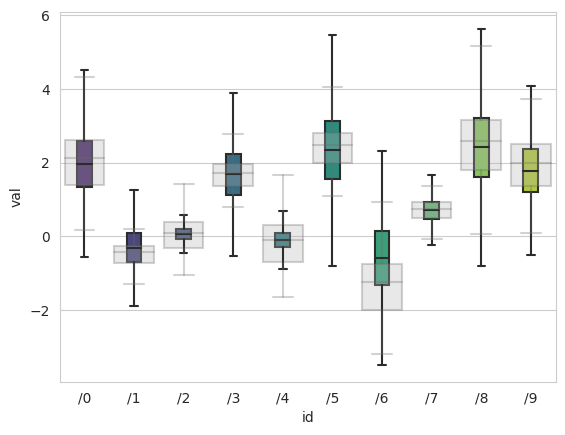

In [225]:

pred_boxplots = convert_to_boxplot(simagg['pred_mean'], simagg['calib_std'])

fig, ax = plt.subplots()
sns.boxplot(data=pred_boxplots, palette='viridis', width=0.3, showfliers=False)
sns.boxplot(x="id", y="val", data=test.sort_values('id'), 
    color='0.7',
    whis=1.5,
    showfliers=False,
    boxprops=dict(alpha=0.3),
    medianprops=dict(alpha=0.3),
    whiskerprops=dict(alpha=0.3),
    capprops=dict(alpha=0.3),
)
plt.show()

In [155]:
dists = pd.read_csv('../data/dists.csv')

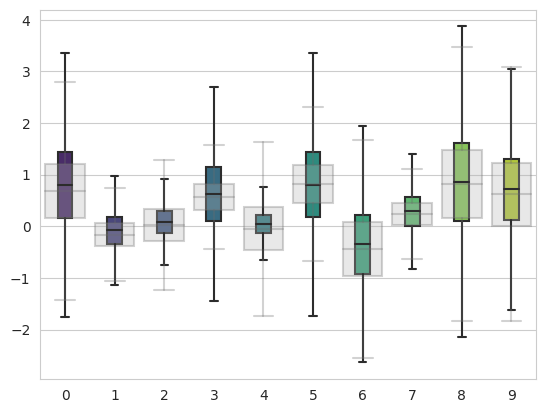

In [156]:
dists_boxplots = convert_to_boxplot(dists['loc'], dists['scale'])

fig, ax = plt.subplots()
sns.boxplot(data=pred_boxplots, palette='viridis', width=0.3, showfliers=False)
sns.boxplot(data=dists_boxplots,
    color='0.7',
    showfliers=False,
    boxprops=dict(alpha=0.3),
    medianprops=dict(alpha=0.3),
    whiskerprops=dict(alpha=0.3),
    capprops=dict(alpha=0.3),
)
plt.show()